In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


## **Load data**

In [2]:
# Load extracted feature dataset
df = pd.read_csv("/content/PING_PONG_FEATURES.csv")

# Drop non-informative or indexing columns if present
drop_cols = ["Unnamed: 0", "index", "id", "timestamp", "trial", "player"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])


## **Target Encoding**

In [3]:
target_col = "action"   # or "label" if you prefer numeric classes

encoder = LabelEncoder()
y = encoder.fit_transform(df[target_col])
class_names = encoder.classes_

X = df.drop(columns=[target_col])


## **Train / Test Split + Scaling**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## **Models to Evaluate**

In [5]:
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_leaf=5,
        random_state=42
    ),
    "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Logistic Regression": LogisticRegression(max_iter=2000)
}


## **Cross-Validation**

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    cv_results[name] = scores
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest: 0.9827 ± 0.0229
SVM (RBF): 0.9766 ± 0.0220
KNN: 0.8899 ± 0.0651
Logistic Regression: 0.9766 ± 0.0343


## **Train Final Models & Evaluate**

In [7]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print("\n" + "="*50)
    print(f"{name} — Test Accuracy: {acc:.4f}")
    print("="*50)
    print(classification_report(y_test, y_pred, target_names=class_names))



Random Forest — Test Accuracy: 0.9655
              precision    recall  f1-score   support

    backhand       0.95      1.00      0.98        20
    forehand       1.00      0.95      0.97        20
       smash       0.94      0.94      0.94        18

    accuracy                           0.97        58
   macro avg       0.97      0.96      0.96        58
weighted avg       0.97      0.97      0.97        58


SVM (RBF) — Test Accuracy: 0.9828
              precision    recall  f1-score   support

    backhand       0.95      1.00      0.98        20
    forehand       1.00      0.95      0.97        20
       smash       1.00      1.00      1.00        18

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58


KNN — Test Accuracy: 0.9310
              precision    recall  f1-score   support

    backhand       0.87      1.00      0.93        20
    forehand       1.00   

# **VISUALIZATIONS**

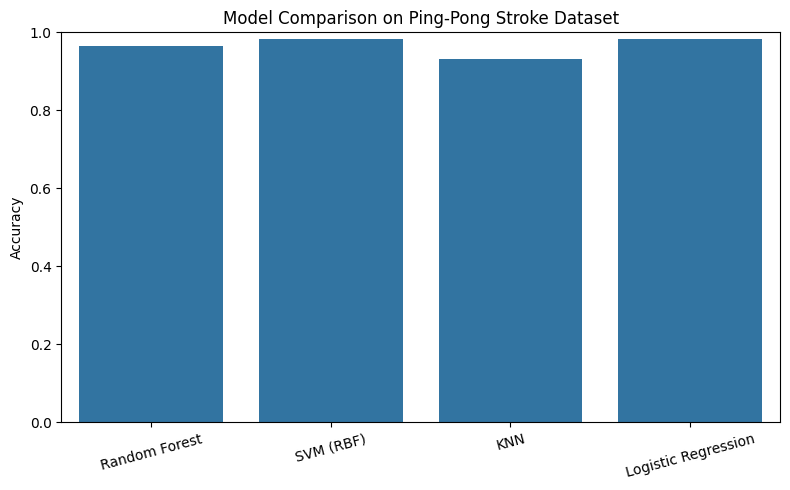

In [8]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Accuracy")
plt.title("Model Comparison on Ping-Pong Stroke Dataset")
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## **Confusion Matrix**

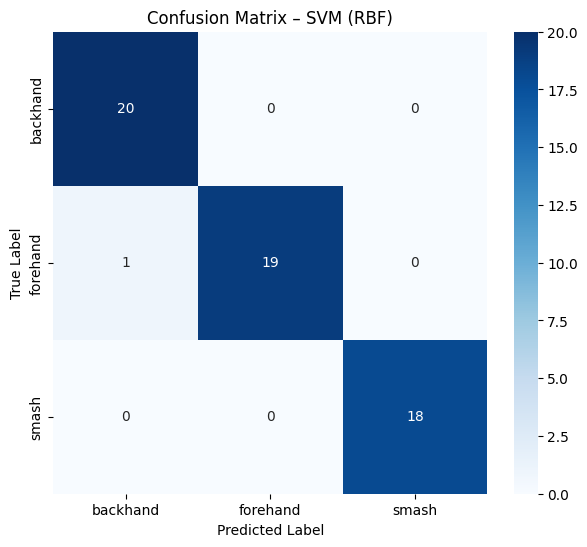

In [9]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

cm = confusion_matrix(y_test, best_model.predict(X_test))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()


## **Feature Importance**

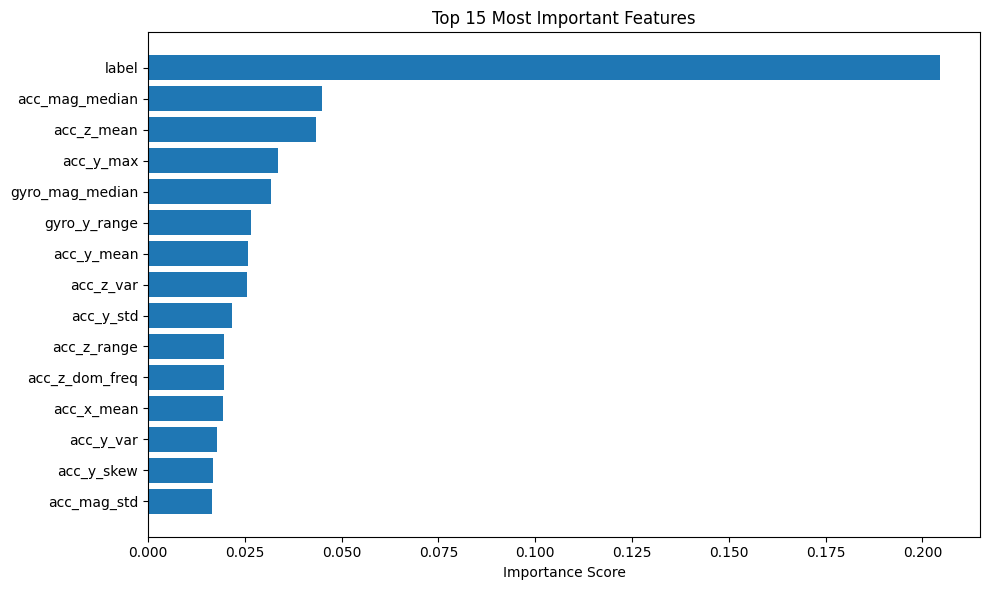

In [10]:
rf = models["Random Forest"]
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel("Importance Score")
plt.title("Top 15 Most Important Features")
plt.tight_layout()
plt.show()
